In [49]:
import pandas as pd 

dataset = pd.read_csv('../data/IBM data/IBM_arg_30k_test.csv') 
dataset.head(3)
len(dataset)
 

6315

In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch

import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import math

In [2]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
import nvidia_smi
nvidia_smi.nvmlInit()

handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

nvidia_smi.nvmlShutdown()

Total memory: 50962169856
Free memory: 39758266368
Used memory: 11203903488


In [4]:
print("Get memory info", torch.cuda.mem_get_info(device=None)) 
print("Get number of devices available: ", torch.cuda.device_count())

print("Memory stats about which device is free: ")

nvidia_smi.nvmlInit()

deviceCount = nvidia_smi.nvmlDeviceGetCount()
for i in range(deviceCount):
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)
    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
    print("Device {}: {}, Memory : ({:.2f}% free): {}(total), {} (free), {} (used)".format(i, nvidia_smi.nvmlDeviceGetName(handle), 100*info.free/info.total, info.total, info.free, info.used))

nvidia_smi.nvmlShutdown()

print("Current Device:  ", torch.cuda.current_device()) 


Get memory info (38582812672, 50962169856)
Get number of devices available:  3
Memory stats about which device is free: 
Device 0: b'Quadro RTX 8000', Memory : (75.71% free): 50962169856(total), 38582812672 (free), 12379357184 (used)
Device 1: b'Quadro RTX 8000', Memory : (99.99% free): 50962169856(total), 50958106624 (free), 4063232 (used)
Device 2: b'Quadro RTX 8000', Memory : (5.26% free): 50962169856(total), 2678521856 (free), 48283648000 (used)
Current Device:   0


In [5]:
torch.cuda.set_device(2)
torch.cuda.empty_cache() 

In [6]:

MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [7]:
class LogicalFallacy(Dataset):
    def __init__(self, dataset, tokenizer, max_len, attribute):
        self.tokenizer = tokenizer
        self.data = dataset
        self.text = dataset[attribute]
        #self.targets = dataset.label
        self.max_len = max_len
        #self.original_label = dataset.updated_label

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        

        return {
            'sentence': text,
            
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            #'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [8]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        softmax = torch.nn.functional.softmax(output)
        return softmax
    



In [9]:
def predict(loader, label, epochs=1):
    model = torch.load('../models/v3/articles/'+label+'_trained_roberta.pt')
    model.eval()
    loss_function = torch.nn.CrossEntropyLoss()
    test_answers = [[[],[]], [[],[]]]
    val = [] 
    for epoch in range(epochs):
        
        for steps, data in tqdm(enumerate(loader, 0)):
            sentence = data['sentence']
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            #targets = data['targets'].to(device, dtype = torch.long)
        
            outputs = model.forward(ids, mask, token_type_ids)
            #print(outputs)
            #print(torch.max(outputs.data, dim=1))
            
            values, max_indices = torch.max(outputs.data, dim=1)
            #val.append(outputs)
            for v in values.tolist():
                val.append(v)
    return val
'''
            if epoch == epochs-1:
                
                for i in range(len(targets)):
                    test_answers[targets[i].item()][max_indices[i].item()].append([
                                                                        sentence[i], 
                                                                        targets[i].item(), 
                                                                        max_indices[i].item()
                                                                        ])
        return test_answers

'''                                            

       


'\n            if epoch == epochs-1:\n                \n                for i in range(len(targets)):\n                    test_answers[targets[i].item()][max_indices[i].item()].append([\n                                                                        sentence[i], \n                                                                        targets[i].item(), \n                                                                        max_indices[i].item()\n                                                                        ])\n        return test_answers\n\n'

In [10]:
def driver_code(label):
   
    test_df = pd.read_csv('../data/IBM data/IBM_arg_30k_test.csv') 
    #test_df = test_df[:50]
    test_set = LogicalFallacy(test_df, tokenizer, MAX_LEN, 'argument')

    
    

    test_params = {'batch_size': 1 ,
                'shuffle': True,
                'num_workers': 0
                }
    
    test_loader = DataLoader(test_set, **test_params)

    
    value = predict(test_loader, label)
    return value



In [11]:
train = pd.read_csv('../data/train_data/v1/edu_train.csv')
unique_labels = train.updated_label.unique().tolist()
unique_labels.remove('appeal to emotion')
print(unique_labels)

['false causality', 'ad populum', 'circular reasoning', 'fallacy of relevance', 'faulty generalization', 'ad hominem', 'fallacy of extension', 'equivocation', 'fallacy of logic', 'fallacy of credibility', 'intentional', 'false dilemma', 'miscellaneous']


In [12]:
test_df = pd.read_csv('../data/IBM data/IBM_arg_30k_test.csv') 
dictionary = { } 
for label in unique_labels:
    dictionary[label] = driver_code(label)



0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/nas/home/vprasann/anaconda3/envs/neuros/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_137250/2446238955.py:17: UserWarning:

FileNotFoundError: [Errno 2] No such file or directory: '../models/v3/articles/miscellaneous_trained_roberta.pt'

Rounding the prediction values

In [13]:
for key in dictionary.keys():
    val = dictionary[key] 
    new_val = [round(elt, 3) for elt in val] 
    dictionary[key] = new_val 

Choosing the maximum prediction value for the sentences among the 12 classes

In [14]:
prediction_value, predicted_class, predictions_every_class = [], [] , {}

for key in dictionary.keys():
    predictions_every_class[key] = []

length_of_dataset = len(dictionary['circular reasoning'])
for i in range(length_of_dataset):
    max_val, label_chosen = -1000, ''

    for key in dictionary.keys():
        predictions_every_class[key].append(dictionary[key][i]) 
        if dictionary[key][i] > max_val:
            max_val = dictionary[key][i] 
            label_chosen = key 
    prediction_value.append(max_val)
    predicted_class.append(label_chosen)


<b>Creating a new dataframe based on the values </b>
<p>
    <ul>
        <li>Arguments</li>
        <li>WA</li>
        <li>Maximum prediction score</li>
        <li>Class predicted</li> 
        <li>Quality</li>
    </ul>
</p>

In [15]:
dataset = test_df[['argument', 'WA']].copy()
dataset['max_pred_score'] = prediction_value
dataset['class_predicted'] = predicted_class
dataset.head(5)

,argument,WA,max_pred_score,class_predicted
0,6 million people died so to deny the holocaust...,0.738337,0.959,false causality
1,a ban would only bring problems in gender equa...,0.721728,0.959,false causality
2,A centralized system of criminal defense would...,0.828674,0.965,faulty generalization
3,a constantly growing population requires large...,0.732927,0.984,ad hominem
4,a country would fall apart under libertarianis...,0.790850,0.988,ad hominem


Calculating quality = 1 - max_prediction_score

In [16]:
dataset['quality'] = 1 - dataset['max_pred_score'] 
dataset.head(5)

,argument,WA,max_pred_score,class_predicted,quality
0,6 million people died so to deny the holocaust...,0.738337,0.959,false causality,0.041
1,a ban would only bring problems in gender equa...,0.721728,0.959,false causality,0.041
2,A centralized system of criminal defense would...,0.828674,0.965,faulty generalization,0.035
3,a constantly growing population requires large...,0.732927,0.984,ad hominem,0.016
4,a country would fall apart under libertarianis...,0.790850,0.988,ad hominem,0.012


In [18]:
import pandas as pd
dataset.to_csv('../data/IBM data/IBM_30k_test_insights.csv',index=False)
dataset = pd.read_csv('../data/IBM data/IBM_30k_test_insights.csv')

Comparing Weighted Accuracy and Quality factor calculated

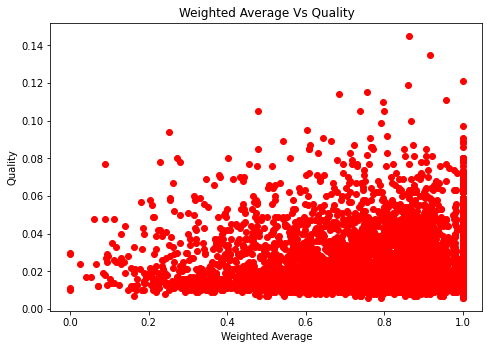

In [19]:
import matplotlib.pyplot as  plt

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(dataset['WA'], dataset['quality'], color='r')

ax.set_xlabel('Weighted Average')
ax.set_ylabel('Quality')
ax.set_title('Weighted Average Vs Quality')
plt.show()

Correlation matrix between WA and Quality

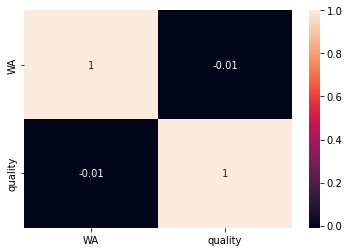

In [21]:
import seaborn as sn 
df = dataset[['WA', 'quality']].copy()
corrMatrix = df.corr()
sn.heatmap(corrMatrix,annot=True)
plt.show()

Calculating the frequency of classes in class prediction

{'ad hominem': 4389, 'faulty generalization': 881, 'ad populum': 613, 'false causality': 177, 'circular reasoning': 159, 'fallacy of extension': 49, 'false dilemma': 43, 'intentional': 3, 'fallacy of credibility': 1}


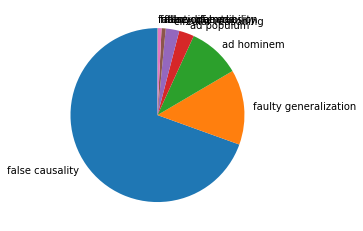

In [48]:
counts = dataset['class_predicted'].value_counts().to_list()
print(dataset['class_predicted'].value_counts().to_dict())
plt.figure()
classes = list(dataset['class_predicted'].unique()) 
plt.pie(counts, labels = classes, startangle = 90)

plt.show() 

In [27]:
train_df = pd.read_csv('../data/train_data/v1/edu_train.csv') 

classes = train_df['updated_label'].unique()
absent_class =[]
for category in classes: 
    if category not in dataset['class_predicted'].unique():
        absent_class.append(category) 

absent_class

In [36]:
absent_class_predictions = {}
for category in absent_class:
    
    absent_class_predictions[category] = predictions_every_class[category]


In [43]:


for absent_category in absent_class:
    absent_class_predictions['difference_'+absent_category] = dataset['max_pred_score'] - absent_class_predictions[absent_category]



In [46]:
from statistics import mean

class_difference_average = {}
for absent_category in absent_class:
    class_difference_average[absent_category]=  mean(absent_class_predictions['difference_'+absent_category])

class_difference_average




{'fallacy of relevance': 0.3069225653206651,
 'equivocation': 0.47437814726840855,
 'fallacy of logic': 0.3146799683293745}